## Training XGBoost model (Jasur)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

USE_AAPL = False  # set to False to run with all stocks

if USE_AAPL:
    base_path = "../../data/processed/processed_AAPL"
else:
    base_path = "../../data/processed/processed_all"

X_train = pd.read_csv(f"{base_path}/X_train.csv")
X_val   = pd.read_csv(f"{base_path}/X_val.csv")
X_test  = pd.read_csv(f"{base_path}/X_test.csv")

y_train = pd.read_csv(f"{base_path}/y_train.csv").iloc[:, 0]
y_val   = pd.read_csv(f"{base_path}/y_val.csv").iloc[:, 0]
y_test  = pd.read_csv(f"{base_path}/y_test.csv").iloc[:, 0]

In [29]:
param_grid_fast = {
    'n_estimators': [100, 300],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

X_combined = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_combined = np.concatenate([y_train, y_val])

print(f"Combined dataset shape: {X_combined.shape}")
print(f"Target shape: {y_combined.shape}")
print(f"Total parameter combinations: {np.prod([len(v) for v in param_grid_fast.values()])}")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

tscv = TimeSeriesSplit(n_splits=5)

Combined dataset shape: (999, 10)
Target shape: (999,)
Total parameter combinations: 32


In [30]:
print("Setting up GridSearchCV...")
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_fast,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=4,
    verbose=1,
    return_train_score=True
)

print(f"Starting GridSearchCV at {datetime.now().strftime('%H:%M:%S')}")
print("This may take several minutes...")

grid_search.fit(X_combined, y_combined)

print(f"GridSearchCV completed at {datetime.now().strftime('%H:%M:%S')}")

print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"Best Score (neg_MSE): {grid_search.best_score_:.6f}")
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_):.6f}")
print(f"Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)

best_xgb = grid_search.best_estimator_

best_xgb.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    # early_stopping_rounds=50,
    verbose=False
)

Setting up GridSearchCV...
Starting GridSearchCV at 16:39:01
This may take several minutes...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
GridSearchCV completed at 16:39:19

GRID SEARCH RESULTS
Best Score (neg_MSE): -66.200049
Best RMSE: 8.136341
Best Parameters:
  colsample_bytree: 1.0
  learning_rate: 0.05
  max_depth: 7
  n_estimators: 300
  subsample: 0.8

TRAINING FINAL MODEL


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)


Training Set Metrics:
  RMSE: 0.170708
  MAE:  0.129767
  R²:   0.999945

Validation Set Metrics:
  RMSE: 2.104122
  MAE:  1.559825
  R²:   0.945005

Test Set Metrics:
  RMSE: 29.339878
  MAE:  26.756470
  R²:   -4.826970

FEATURE IMPORTANCE (Top 10)
    feature  importance
        low    0.491700
       high    0.331909
 close_ma_5    0.056806
close_lag_1    0.052090
       open    0.050423
close_lag_2    0.010614
close_ma_10    0.003704
close_lag_3    0.001966
close_std_5    0.000410
     volume    0.000379


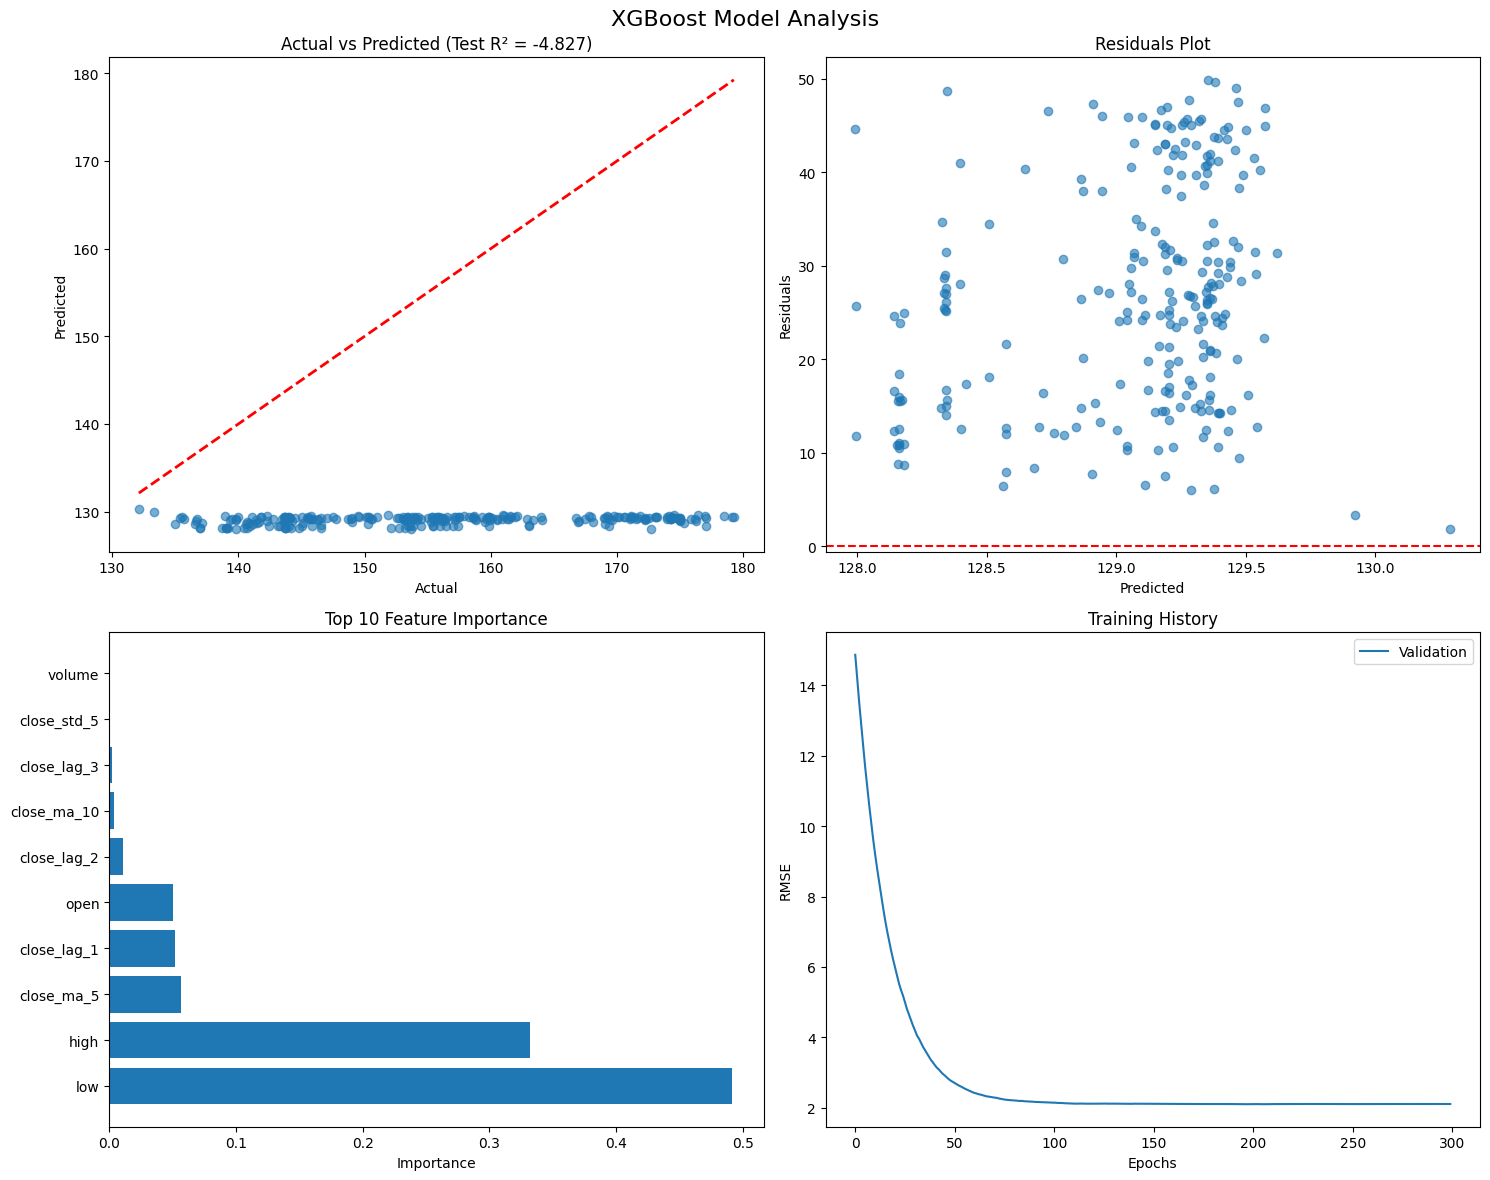


TOP 5 PARAMETER COMBINATIONS

1. Score: -66.200049 (±99.599421)
   Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

2. Score: -66.290162 (±99.704351)
   Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

3. Score: -66.311025 (±99.308731)
   Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}

4. Score: -66.417265 (±99.475051)
   Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}

5. Score: -66.469056 (±99.826966)
   Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

Best model saved as 'xgboost_model'
Results summary saved as 'xgboost_results.json'

GRID SEARCH COMPLETE!
Best model RMSE on test set: 29.339878


In [34]:
y_train_pred = best_xgb.predict(X_train)
y_val_pred = best_xgb.predict(X_val)
y_test_pred = best_xgb.predict(X_test)

def calculate_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Set Metrics:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
val_metrics = calculate_metrics(y_val, y_val_pred, "Validation") 
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Top 10)")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('XGBoost Model Analysis', fontsize=16)

axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].set_title(f'Actual vs Predicted (Test R² = {test_metrics["R2"]:.3f})')

residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals Plot')

top_features = feature_importance.head(10)
axes[1, 0].barh(range(len(top_features)), top_features['importance'])
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 10 Feature Importance')

if hasattr(best_xgb, 'evals_result_'):
    eval_results = best_xgb.evals_result_
    epochs = len(eval_results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    axes[1, 1].plot(x_axis, eval_results['validation_0']['rmse'], label='Validation')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('RMSE')
    axes[1, 1].set_title('Training History')
    axes[1, 1].legend()
else:
    metrics_df = pd.DataFrame({
        'Train': [train_metrics['RMSE'], train_metrics['MAE'], train_metrics['R2']],
        'Validation': [val_metrics['RMSE'], val_metrics['MAE'], val_metrics['R2']],
        'Test': [test_metrics['RMSE'], test_metrics['MAE'], test_metrics['R2']]
    }, index=['RMSE', 'MAE', 'R²'])
    
    metrics_df.plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Metrics Comparison')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TOP 5 PARAMETER COMBINATIONS")
print("="*60)

results_df = pd.DataFrame(grid_search.cv_results_)
top_results = results_df.nlargest(5, 'mean_test_score')[
    ['mean_test_score', 'std_test_score', 'params']
]

for idx, (_, row) in enumerate(top_results.iterrows(), 1):
    print(f"\n{idx}. Score: {row['mean_test_score']:.6f} (±{row['std_test_score']:.6f})")
    print(f"   Parameters: {row['params']}")

import os
path = '../../../models'
os.makedirs('../../../models', exist_ok=True)

best_xgb.save_model(os.path.join(path, 'xg_boost_model.csv'))
print(f"\nBest model saved as 'xgboost_model'")

results_summary = {
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_,
    'train_metrics': train_metrics,
    'val_metrics': val_metrics,
    'test_metrics': test_metrics,
    'feature_importance': feature_importance.head(20).to_dict()
}

import json
with open(os.path.join(path, 'xgboost_results.json'), 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)
print("Results summary saved as 'xgboost_results.json'")

print(f"\n{'='*60}")
print("GRID SEARCH COMPLETE!")
print(f"Best model RMSE on test set: {test_metrics['RMSE']:.6f}")
print(f"{'='*60}")

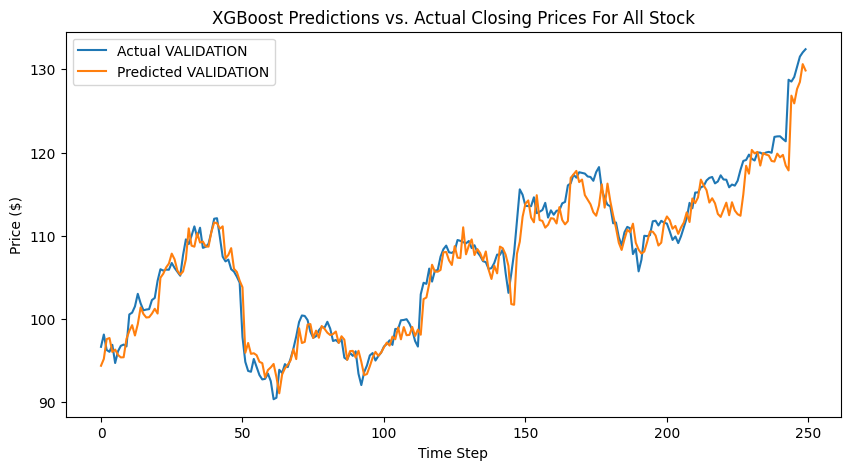

In [32]:
# actual vs predicted (validation)
plt.figure(figsize=(10, 5))
plt.plot(y_val.values, label='Actual VALIDATION')
plt.plot(y_val_pred, label='Predicted VALIDATION')
plt.title('XGBoost Predictions vs. Actual Closing Prices For All Stock')
plt.xlabel('Time Step')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

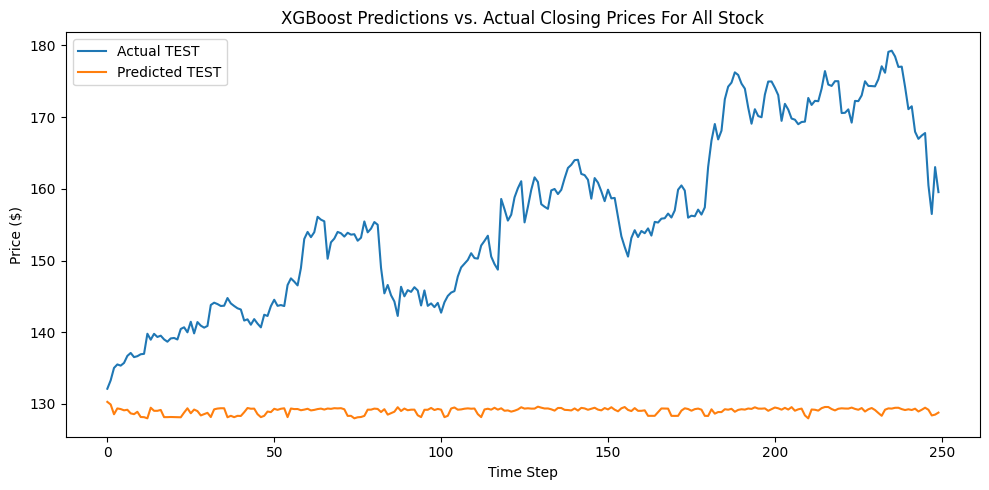

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual TEST')
plt.plot(y_test_pred, label='Predicted TEST')
plt.title('XGBoost Predictions vs. Actual Closing Prices For All Stock')
plt.xlabel('Time Step')
plt.ylabel('Price ($)')
plt.legend()
plt.tight_layout()
plt.show()